<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/develop/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [1]:
!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

以下のPythonライブラリを利用
- urllib
- bs4

In [3]:
# 水位観測所IDの設定
loc = '260' # 小千谷市 ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （11番目付近）

# 解析期間の設定
dts = '2020070100' # 開始日時
dte = '2020071500' # 終了日時
interval = 1 # hour

# Webからの水位情報抽出
dts00 = pd.to_datetime(dts+'00')
dte00 = pd.to_datetime(dte+'00')
td = dte00 - dts00
durationinhours = int(td.total_seconds()/(3600))
t = [ [] for idx in range(durationinhours) ]
y = [ 0.0 for idx in range(durationinhours) ]
idt = dts00
idx = 0
while idt < dte00:
    # 水位抽出日時の設定
    strdt = idt.strftime('%Y%m%d%H%M')
    ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

    # URLの設定
    url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

    # 指定した時刻の水位情報抽出
    response = request.urlopen(url)
    soup = BeautifulSoup(response)
    response.close()
    if idt == dts00:
        strtitle = soup.title.text.strip()
    #print(soup.find('td', class_='tableHeaderCast').text.strip())
    strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
    waterlevel = float(strwaterlevel.replace('---','nan'))

    # リストへのデータ登録
    t[idx] = ts
    y[idx] = waterlevel

    # 時間を更新
    idx += 1
    idt += offsets.Hour(interval)


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [4]:
df_timeseries= pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2020-07-01 00:00:00+09:00,42.27
1,2020-07-01 01:00:00+09:00,42.29
2,2020-07-01 02:00:00+09:00,42.31
3,2020-07-01 03:00:00+09:00,42.32
4,2020-07-01 04:00:00+09:00,42.43
...,...,...
331,2020-07-14 19:00:00+09:00,44.25
332,2020-07-14 20:00:00+09:00,44.24
333,2020-07-14 21:00:00+09:00,44.24
334,2020-07-14 22:00:00+09:00,44.32


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


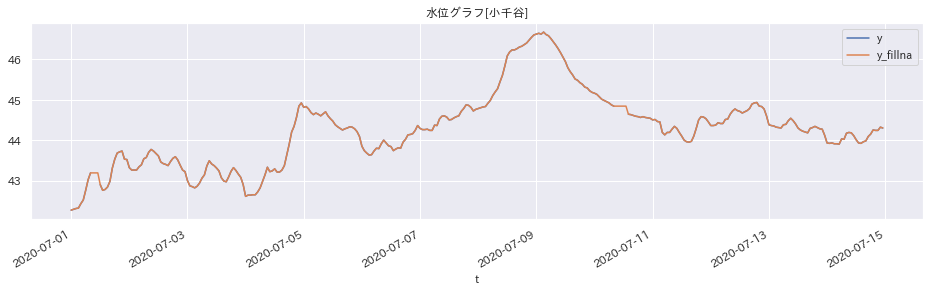

In [5]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
ax = df_timeseries.plot(x='t', y={'y', 'y_fillna'}, figsize=(16,4), title=strtitle)


ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

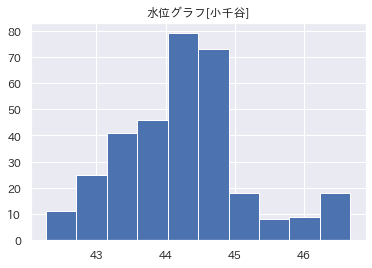

In [6]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで 

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [7]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1) 
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 44.264756, 分散 = 0.854936


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [8]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 0.854936, ρ0 = 1.000000
γ1 = 0.846790, ρ1 = 0.994758
γ2 = 0.831688, ρ2 = 0.982872
γ3 = 0.811612, ρ3 = 0.966316
γ4 = 0.790689, ρ4 = 0.947134
γ5 = 0.771372, ρ5 = 0.927458
γ6 = 0.754002, ρ6 = 0.909901
γ7 = 0.741536, ρ7 = 0.895285
γ8 = 0.732485, ρ8 = 0.883549
γ9 = 0.724433, ρ9 = 0.873098
γ10 = 0.719710, ρ10 = 0.861380
γ11 = 0.711290, ρ11 = 0.846217
γ12 = 0.699557, ρ12 = 0.827345
γ13 = 0.677508, ρ13 = 0.803450
γ14 = 0.651937, ρ14 = 0.775846
γ15 = 0.625039, ρ15 = 0.746507
γ16 = 0.598921, ρ16 = 0.717290
γ17 = 0.575168, ρ17 = 0.689737
γ18 = 0.555611, ρ18 = 0.666205
γ19 = 0.540421, ρ19 = 0.647147
γ20 = 0.528034, ρ20 = 0.631553
γ21 = 0.517533, ρ21 = 0.618446
γ22 = 0.507553, ρ22 = 0.606582
γ23 = 0.495814, ρ23 = 0.593326
γ24 = 0.482275, ρ24 = 0.578523
γ25 = 0.464044, ρ25 = 0.558722
γ26 = 0.443440, ρ26 = 0.536161
γ27 = 0.422266, ρ27 = 0.512672
γ28 = 0.401306, ρ28 = 0.489004
γ29 = 0.382756, ρ29 = 0.467383
γ30 = 0.367779, ρ30 = 0.449576
γ31 = 0.357577, ρ31 = 0.436643
γ32 = 0.350696, ρ32 = 0.4274

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [9]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,unbiased=True)
display(y_acf)


自己共分散関数


array([ 0.84727217,  0.8393089 ,  0.82582414,  0.80866702,  0.78945516,
        0.7707485 ,  0.75421412,  0.74113779,  0.73105141,  0.72260811,
        0.71323587,  0.70135006,  0.68626002,  0.66657745,  0.64312181,
        0.61794531,  0.59285379,  0.56963054,  0.55047811,  0.5352223 ,
        0.52352088,  0.51351313,  0.50409656,  0.49307996,  0.48067863,
        0.46394502,  0.44523033,  0.42607911,  0.40734447,  0.39095393,
        0.37795684,  0.36918496,  0.36324682,  0.3598545 ,  0.35741135,
        0.35377742,  0.34802548,  0.33995162,  0.32871598,  0.31575712,
        0.30262355,  0.29029535,  0.28089225,  0.27477309,  0.27157122,
        0.2697973 ,  0.26787228,  0.26481799,  0.26016203,  0.25104051,
        0.23895678,  0.2255372 ,  0.2118232 ,  0.19958925,  0.19011556,
        0.18408881,  0.18102039,  0.18095876,  0.18261134,  0.18307041,
        0.18189475,  0.17895692,  0.17421438,  0.16740261,  0.15995988,
        0.15334   ,  0.14980928,  0.14965545,  0.15236255,  0.15

自己相関関数


array([1.        , 0.99060128, 0.97468578, 0.95443596, 0.93176099,
       0.90968231, 0.89016746, 0.87473401, 0.86282949, 0.85286421,
       0.84180254, 0.82777422, 0.80996407, 0.78673355, 0.75904985,
       0.72933507, 0.69972059, 0.67231117, 0.64970635, 0.63170056,
       0.61788985, 0.60607812, 0.59496415, 0.58196171, 0.56732493,
       0.54757495, 0.52548679, 0.5028834 , 0.48077168, 0.46142662,
       0.44608669, 0.4357336 , 0.42872507, 0.42472125, 0.42183771,
       0.41754874, 0.41075996, 0.40123071, 0.38796976, 0.37267496,
       0.35717395])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

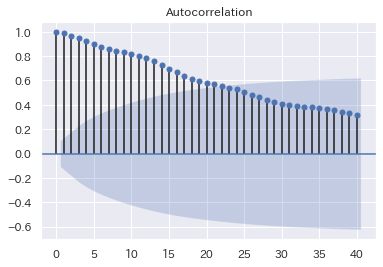

In [10]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2020-07-01 00:00:00+09:00,42.27,42.27,NaN
1,2020-07-01 01:00:00+09:00,42.29,42.29,0.02
2,2020-07-01 02:00:00+09:00,42.31,42.31,0.02
3,2020-07-01 03:00:00+09:00,42.32,42.32,0.01
4,2020-07-01 04:00:00+09:00,42.43,42.43,0.11
...,...,...,...,...
331,2020-07-14 19:00:00+09:00,44.25,44.25,0.10
332,2020-07-14 20:00:00+09:00,44.24,44.24,-0.01
333,2020-07-14 21:00:00+09:00,44.24,44.24,0.00
334,2020-07-14 22:00:00+09:00,44.32,44.32,0.08


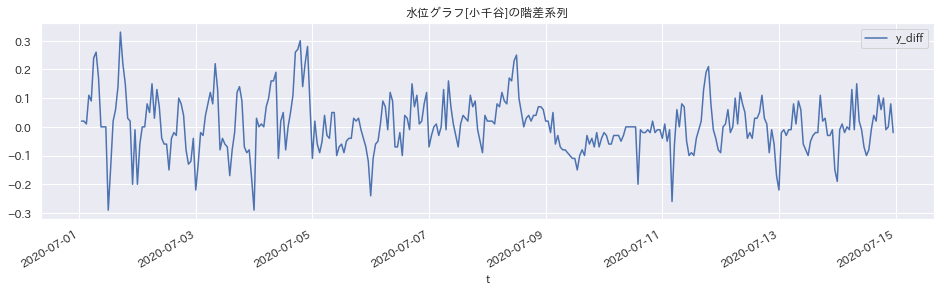

In [11]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]')

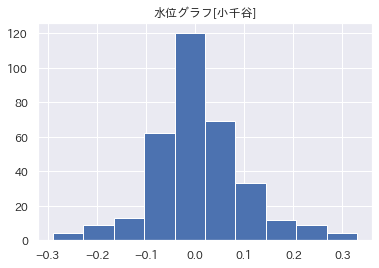

In [12]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle)

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [13]:
#df_timeseries.to_csv('./data/sample02_03.csv',index=False)